### Loading QE Data

To some extent the ['developers manual'](https://gitlab.com/QEF/q-e/-/wikis/Developers/Format-of-data-files) helps

In [138]:
np.where(np.all(miller_indices==[83,83,83]))

/tmp/ipykernel_872811/3320563769.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(np.all(miller_indices==[83,83,83]))


(array([], dtype=int64),)

In [218]:
import h5py
import numpy as np
from scipy.fft import ifftn, ifftshift
import pyvista as pv

# Function to read the charge density from the HDF5 file
def read_charge_density(filename):
    with h5py.File(filename, 'r') as f:
        miller_indices = f['MillerIndices'][:]
        charge_density_g = f['rhotot_g'][:]
    print(miller_indices.shape)
    return miller_indices, charge_density_g

# Function to reshape and transform the charge density
def transform_charge_density(miller_indices, charge_density_g):
    # Determine the grid size from Miller indices
    max_positive_val = miller_indices.max()
    oneD_size =  int(max_positive_val*2 + 1)
    grid_size = (oneD_size, oneD_size, oneD_size)
    print(f"grid_size={grid_size}")
    print(f"charge_density_g shape: {charge_density_g.shape}")
    # Initialize an empty complex array
    charge_density_g_complex = np.zeros(grid_size, dtype=complex)
    
    # Fill the complex array with values from charge_density_g
    for index, value in zip(miller_indices, charge_density_g):
        # if (index==[0,0,0]).all():
        charge_density_g_complex[ tuple(np.array(index) + max_positive_val) ] = value
        mirror_x_index = [-index[0], index[1], index[2]]
        charge_density_g_complex[ tuple(mirror_x_index + max_positive_val) ] = value # Handles negative x
        if index[0]==0 and index[1]==0:
            mirror_z_index = [index[0], index[1], -index[2]]
            charge_density_g_complex[ tuple(mirror_z_index + max_positive_val) ] = value # Handles negative z for x=y=0
        if index[0]==0 and index[1]!=0:
            mirror_y_index = [index[0], -index[1], index[2]]
            charge_density_g_complex[ tuple(mirror_y_index + max_positive_val) ] = value # Handles negative z for x=y=0
    
    # Perform the inverse Fourier transform to get real space charge density
    shifted_charge = ifftshift(charge_density_g_complex)
    print(shifted_charge[0,0,0], shifted_charge[83,83,83])
    # charge_density_real = np.real(ifftn(shifted_charge))
    charge_density_real = ifftn(shifted_charge)
    
    return charge_density_g_complex, charge_density_real

# Function to save the charge density to a VTK file
def save_charge_density_vtk(charge_density, filename):
    # Create a PyVista ImageData object
    grid = pv.ImageData()

    # Set the dimensions of the grid
    grid.dimensions = np.array(charge_density.shape) + 1

    # Set the spacing (assuming unit spacing, adjust if necessary)
    spacing = np.array((1, 1, 1))*L/N_points  # Adjust this if your grid spacing is different
    grid.spacing = spacing

    # Set the origin (assuming origin at (0,0,0), adjust if necessary)
    grid.origin = (0, 0, 0)

    # Assign the charge density data to the grid
    grid.cell_data["Charge Density"] = charge_density.flatten(order="F")

    # Save the grid to a VTK file
    grid.save(filename)
    return grid

L = 24.7938 

filename = 'charge-density.hdf5'
miller_indices, charge_density_g = read_charge_density(filename)
N_points = np.max(miller_indices) - np.min(miller_indices) + 1

charge_density_g_grid, charge_density_real = transform_charge_density(miller_indices, charge_density_g)

Δcharge_density_g_grid =  charge_density_g_grid.copy()
Δcharge_density_g_grid[0,0,0] = 0

# Save the charge density to a VTK file
vtk_filename = 'charge_density_r.vtk'
grid = save_charge_density_vtk(charge_density_real, vtk_filename)

# vtk_filename = 'charge_density_k.vtk'
# save_charge_density_vtk(charge_density_g_grid.real, vtk_filename)

# vtk_filename = 'Δcharge_density_k.vtk'
# save_charge_density_vtk(Δcharge_density_g_grid.real, vtk_filename)

print(f"Charge density saved to {vtk_filename}")



(1228360, 3)
grid_size=(167, 167, 167)
charge_density_g shape: (2456720,)
(0.01968303087989512+0j) 0j
Charge density saved to charge_density_r.vtk


In [235]:
# Compare each row in the Nx3 array to the target array
g_position_1 = [1,2,3]
g_position_2 = [1,2,-3]
miller_1, miller_2 = [np.where(np.all(miller_indices == g_pos, axis=1))[0] for g_pos in [g_position_1, g_position_2]]
print(miller_1, miller_2)
print(charge_density_g[miller_1],  charge_density_g[miller_2])


[107] [106]
[0.0001147] [0.0001468]


In [221]:
miller_indices[:10]

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  1,  0],
       [ 1,  0,  0],
       [ 0,  1, -1],
       [ 0,  1,  1],
       [ 1, -1,  0],
       [ 1,  0, -1],
       [ 1,  0,  1],
       [ 1,  1,  0]], dtype=int32)

In [217]:
np.savetxt("miller_indices.txt", np.vstack( [['H']*1228360, miller_indices.T]).T, fmt='%s', header="1228360\n",comments='')

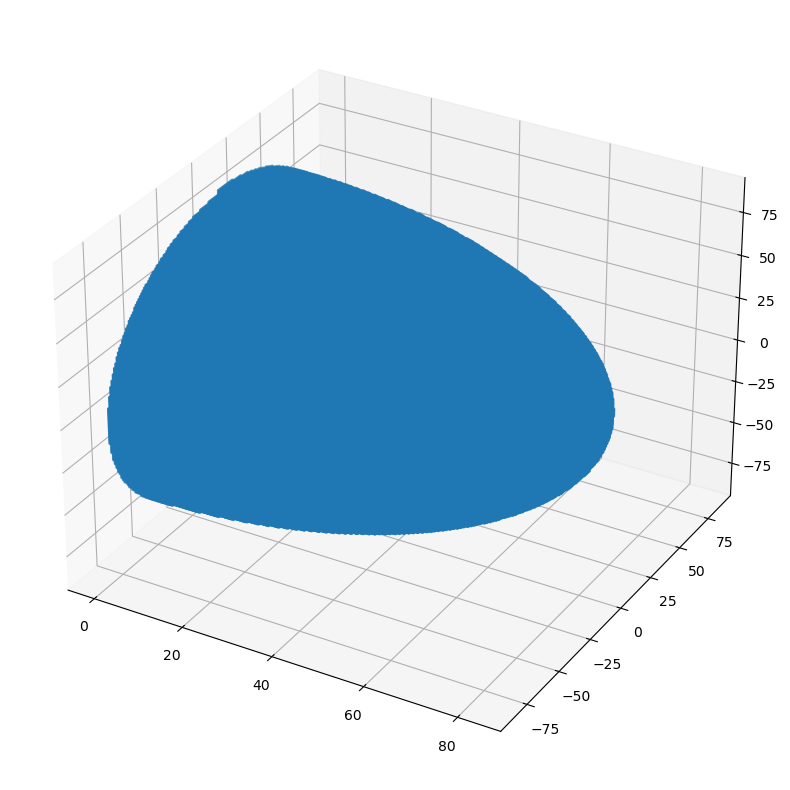

In [209]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

last = None
ax.scatter(miller_indices[:last,0], miller_indices[:last,1], miller_indices[:last,2], s=3)

In [219]:
np.min(charge_density_real), np.max(charge_density_real), np.mean(charge_density_real), np.std(charge_density_real)

((-9.426538722586452e-08+9.784208259148126e-09j),
 (9.940849727545612e-08-3.004262176635344e-08j),
 (4.226127159763828e-09+2.8652947074386853e-25j),
 2.709674102349195e-08)

In [186]:
grid

ImageData (0x7a8343e25480)
  N Cells:      4657463
  N Points:     4741632
  X Bounds:     0.000e+00, 2.479e+01
  Y Bounds:     0.000e+00, 2.479e+01
  Z Bounds:     0.000e+00, 2.479e+01
  Dimensions:   168, 168, 168
  Spacing:      1.485e-01, 1.485e-01, 1.485e-01
  N Arrays:     1

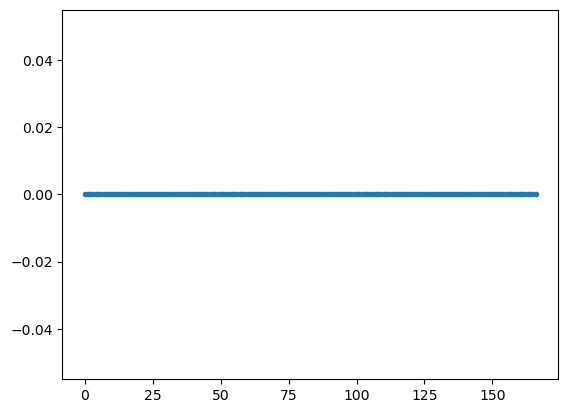

In [167]:
fig, ax  = plt.subplots()

ax.plot(charge_density_g_grid.real[0,0,:],'--.')

